In [6]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from random import randrange
from wordcloud import WordCloud

In [7]:
# Baixar recursos do NLTK (se necessário)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
stopwords_especificas = [
    "vc", "voce", "vcs", "tá", "ta", "to", "tô", "pq", "q", "né", "eh", "ai", "aí", "c", "d", "já",
    "pro", "pra", "pras", "nois", "tbm", "tb", "que", "oq", "ctz", "td", "toda", "todo", "todos", "ja",
    "ate", "até", "dps", "qdo", "cm", "rt", "from", "rs", "aff", "dae", "dai", "so", "só", "la", "lá","cade",
    "xq", "x", "tam", "vlw", "obg", "ne", "n", "ñ", "nn", "nao", "sim", "s", "ss", "pfv", "pf", "plz",
    "cadê", "kd", "aki", "aqui", "ali", "dali", "naquele", "naquela", "naquilo", "aonde", "dela", "dele",
    "deles", "delas", "mt", "mto", "mtos", "mta", "mtas", "oh", "ah", "ui", "ops", "lol", "ftw",
    "oxe", "argh", "eita", "ih", "ui", "epa", "oba", "ufa", "aham", "hmm", "hm", "hi", "hein", "puf",
    "tipo", "tipo assim", "mano", "cara", "vei", "gente", "galera", "fia", "fi", "tamo", "vamo", "bora",
    "sao", "vai", "vem", "aonde", "donde", "onde", "aqui", "dali", "ma", "meu", "minha", "nosso", "nossa"
]

abrevicoes_odiosas = [
    "wtf", "pqp", "vsfd", "sfd", "vtmnc", "vtmc", "tmnk", "tmnc", "fdp", "fds", "k7", "kct", "prr", "mrda", "merd", "mrd", "bct", "pk", "xt", "krl",
    "crl", "bct", "bp", "nc", "vdd", "viad", "vyd", "bait", "beyt", "bixa", "bixy", "bixa", "bixy", "fudr", "fodr", "fodase", "crlh", "crl", "caralh",
    "carlh", "porr", "p0rr4", "p0rr@", "fuder", "fud3r", "f0d3r", "f0der", "mcl", "m3rd4", "m3rd@", "merd4", "merd@", "bocet", "b0cet", "boc3t", "b0c3t",
    "bucet", "buc3t", "b0cet", "b0c3t", "pint0", "pint@", "p1nt@", "p1nt0", "rola", "r0l@", "r0l4", "rol4", "rol@", "vagabund", "vagabund@", "vagabund4", "vagabund0",
    "vgbd","vadia", "vadi4", "vadi@", "v4di@", "v4di4", "puta", "put4", "put@", "dbf", "aut", "rtd", "cuz4o", "cuz@o", "cuz4@", "cuz@", "stpr"
]
    
abrevicoes_odiosas = set(abrevicoes_odiosas)

stopwords_tradicionais = set(stop_words)

stopwords_especificas = set(stopwords_especificas)

STOPWORDS_COMPLETA = stopwords_tradicionais.union(stopwords_especificas)

In [14]:
def remover_palavras_exatas(texto: str, palavras: list[str]) -> str:
    """
    Remove palavras exatas do texto usando regex, sem remover substrings.

    Args:
        texto (str): Texto de entrada.
        palavras (list[str]): Lista de palavras a remover (exatamente).

    Returns:
        str: Texto com as palavras removidas.
    """
    for palavra in palavras:
        # Remove a palavra com delimitador de palavra (\b) e insensível a maiúsculas
        padrao = rf'\b{re.escape(palavra)}\b'
        texto = re.sub(padrao, '', texto, flags=re.IGNORECASE)

    # Limpa múltiplos espaços e espaços antes de pontuação
    texto = re.sub(r'\s{2,}', ' ', texto)
    texto = re.sub(r'\s+([,.!?;:])', r'\1', texto)

    return texto.strip()

In [9]:
# 2. Pré-processamento (corrigido) [99%]
import unicodedata
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def clean_text(text, lemmatizer=False):
    '''
    Perform stop-words removal and lemmatization
    '''

    text = str(text)

    if lemmatizer:
        words = [word for word in text.split()]
        words = [WordNetLemmatizer().lemmatize(word) for word in words]
        return " ".join(words)
    
    text = text.lower()

    text_normalize = unicodedata.normalize("NFKD", text)
    text = ''.join(
        char for char in text_normalize
        if not unicodedata.combining(char)
    )

    text = text.encode('ascii', 'ignore').decode('utf-8')

    words = text.split()
    for word in words:
        if re.search('http', word) or re.search('https', word):
            text = text.replace(word, '')

        if re.search('@', word) or re.search('#', word):
            text = text.replace(word, '')

        if re.search('kk', word) or re.search("hah", word) or re.search('aha', word):
            text = text.replace(word, '')

        if word in abrevicoes_odiosas:
            for abrev in abrevicoes_odiosas:
                if re.search(abrev, word) and len(abrev) == len(word):
                    text = text.replace(abrev, 'KKK')
                

    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    words = [word for word in text.split() if (word not in STOPWORDS_COMPLETA)]


    return " ".join(words)

In [22]:
#Criação de Datasets limpos
import os
import re

pasta_atual = os.getcwd()
if os.path.exists(pasta_atual+"/Datasets"):
    pasta_datasets_sujos = os.path.join(pasta_atual, "Datasets")
    datasets_paths = []

    if os.path.exists(pasta_datasets_sujos+"/OLID - BR"):
        pasta_olid = os.path.join       (pasta_datasets_sujos, "OLID - BR")
        arquivo_olid = os.path.join(pasta_olid, "2019-05-28_portuguese_hate_speech_binary_classification.csv")
        datasets_paths.append(arquivo_olid)

    if os.path.exists(pasta_datasets_sujos+"/OffComBR-3"):
        pasta_offcomTres = os.path.join(pasta_datasets_sujos, "OffComBR-3")
        arquivo_offcomTres = os.path.join(pasta_offcomTres, "OffComBR3.csv")
        datasets_paths.append(arquivo_offcomTres)

    if os.path.exists(pasta_datasets_sujos+"/Offcom2"):
        pasta_offcomDois = os.path.join   (pasta_datasets_sujos, "Offcom2")
        arquivo_offcomDois = os.path.join(pasta_offcomDois, "OffComBR2.csv")
        datasets_paths.append(arquivo_offcomDois)

    if os.path.exists(pasta_datasets_sujos+"/ToLD"):
        pasta_told = os.path.join            (pasta_datasets_sujos, "ToLD")
        arquivo_told = os.path.join(pasta_told, "ToLD-BR_binario.csv")
        datasets_paths.append(arquivo_told)

    if os.path.exists(pasta_datasets_sujos+"/hateBR"):
        pasta_hate = os.path.join          (pasta_datasets_sujos, "hateBR")
        arquivo_hate = os.path.join(pasta_hate, "HateBR.csv")
        datasets_paths.append(arquivo_hate)
    
    # multioffcom3
    if os.path.exists(pasta_datasets_sujos+"/OffComBR-3"):
        pasta_multiOffcomTres = os.path.join(pasta_datasets_sujos, "OffComBR-3")
        arquivo_multiOffcomTres = os.path.join(pasta_multiOffcomTres, "MultiOffComBR3.csv")
        datasets_paths.append(arquivo_multiOffcomTres)

text=['text','mensagem','comentario','text','comentario']
label = ['hatespeech_comb','label','label','Discurso_de_odio','label_final']

if not os.path.exists("Datasets Limpos"):
    os.mkdir("Datasets Limpos")

In [10]:
datasets = [
    'Datasets/OLID - BR/2019-05-28_portuguese_hate_speech_binary_classification.csv',
    'Datasets/OffComBR-3/OffComBR3.csv',
    'Datasets/Offcom2/OffComBR2.csv',
    'Datasets/ToLD/ToLD-BR_binario.csv',
    'Datasets/hateBR/HateBR.csv'
]

text=['text','mensagem','comentario','text','comentario']
label = ['hatespeech_comb','label','label','Discurso_de_odio','label_final']
for dataset,label in zip(datasets,label) :
  df = pd.read_csv(dataset)
  print("Coleção de dados : {}\nShape : {}\nInstâncias : {}\n\n".format(
      dataset.split('/')[-1],
      df.shape,
      df[label].value_counts()
      ))


Coleção de dados : 2019-05-28_portuguese_hate_speech_binary_classification.csv
Shape : (5670, 8)
Instâncias : hatespeech_comb
0    3882
1    1788
Name: count, dtype: int64


Coleção de dados : OffComBR3.csv
Shape : (1033, 2)
Instâncias : label
no     831
yes    202
Name: count, dtype: int64


Coleção de dados : OffComBR2.csv
Shape : (1250, 2)
Instâncias : label
no     831
yes    419
Name: count, dtype: int64


Coleção de dados : ToLD-BR_binario.csv
Shape : (21000, 15)
Instâncias : Discurso_de_odio
0    11742
1     9258
Name: count, dtype: int64


Coleção de dados : HateBR.csv
Shape : (7000, 8)
Instâncias : label_final
1    3500
0    3500
Name: count, dtype: int64




In [7]:
import random
for text_,dataset in zip(text,datasets):
  df = pd.read_csv(dataset)
  texto = df[text_]
  texto = texto[random.randrange(len(df))]
  limpo = clean_text(texto)
  lemmatizado = clean_text(texto, lemmatizer=True)
  print("Texto Original : {}\nTexto Limpo : {}\nTexto Limpo e Lemmatizado : {}\n\n".format(texto,limpo,lemmatizado))


Texto Original : RT @pauloap: Porra, olha a série de reportagens que o Jornal da Record estreia hoje, nunca que a Globo faria https://t.co/1QzI4oabRD
Texto Limpo : porra olha serie reportagens jornal record estreia hoje nunca globo faria
Texto Limpo e Lemmatizado : RT @pauloap: Porra, olha a série de reportagens que o Jornal da Record estreia hoje, nunca que a Globo faria https://t.co/1QzI4oabRD


Texto Original : 'O que esta OPOSICAO esta conseguindo e atrair para si e para os proximos e o odio dos eleitores '
Texto Limpo : oposicao conseguindo atrair si proximos odio eleitores
Texto Limpo e Lemmatizado : 'O que esta OPOSICAO esta conseguindo e atrair para si e para o proximos e o odio do eleitores '


Texto Original : 'Um volante da base PELO AMOR DE DEUS para o lugar de Marcio AraujoPELA AMOR'
Texto Limpo : volante base amor deus lugar marcio araujopela amor
Texto Limpo e Lemmatizado : 'Um volante da base PELO AMOR DE DEUS para o lugar de Marcio AraujoPELA AMOR'


Texto Original : r

In [11]:
import pandas as pd
import numpy as np

# Lista de datasets e suas respectivas colunas
datasets = [
    'Datasets/OLID - BR/2019-05-28_portuguese_hate_speech_binary_classification.csv',
    'Datasets/OffComBR-3/OffComBR3.csv',
    'Datasets/Offcom2/OffComBR2.csv',
    'Datasets/ToLD/ToLD-BR_binario.csv',
    'Datasets/hateBR/HateBR.csv'
]

text_columns = ['text', 'mensagem', 'comentario', 'text', 'comentario']
label_columns = ['hatespeech_comb', 'label', 'label', 'Discurso_de_odio', 'label_final']

results = []
try:
    # Ler o dataset para criação Global
    df = pd.read_csv(datasets[0])
except Exception as e:
    print(f"Erro ao processar {dataset[0]}: {str(e)}")

for i, dataset_path in enumerate(datasets):
    try:
        # Ler o dataset
        df = pd.read_csv(dataset_path)
        
        # Obter colunas de texto e label
        text_col = text_columns[i]
        label_col = label_columns[i]
        
        # Calcular estatísticas
        num_instances = len(df)
        
        # Tamanho médio em palavras
        avg_word_length = df[text_col].apply(lambda x: len(str(x).split())).mean()
        
        # Tamanho médio em caracteres
        avg_char_length = df[text_col].apply(lambda x: len(str(x))).mean()
        
        # Número de classes
        num_classes = df[label_col].nunique()
        
        # Distribuição de classes
        class_distribution = df[label_col].value_counts().to_dict()
        
        # Formatar distribuição para melhor visualização
        dist_str = ", ".join([f"{k}: {v}" for k, v in class_distribution.items()])
        
        results.append({
            'Dataset': dataset_path.split('/')[1],
            '# Instâncias': num_instances,
            'Tamanho Médio (palavras)': round(avg_word_length, 2),
            'Tamanho Médio (caracteres)': round(avg_char_length, 2),
            '# Classes': num_classes,
            'Distribuição de Classes': dist_str
        })
        
    except Exception as e:
        print(f"Erro ao processar {dataset_path}: {str(e)}")

# Criar DataFrame com resultados
results_df = pd.DataFrame(results)
print(results_df)

# Salvar resultados em CSV
# results_df.to_csv('estatisticas_datasets.csv', index=False)

      Dataset  # Instâncias  Tamanho Médio (palavras)  \
0   OLID - BR          5670                     15.81   
1  OffComBR-3          1033                     13.70   
2     Offcom2          1250                     13.21   
3        ToLD         21000                     15.62   
4      hateBR          7000                     13.93   

   Tamanho Médio (caracteres)  # Classes Distribuição de Classes  
0                      101.35          2        0: 3882, 1: 1788  
1                       77.21          2       no: 831, yes: 202  
2                       74.56          2       no: 831, yes: 419  
3                       87.02          2       0: 11742, 1: 9258  
4                       81.96          2        1: 3500, 0: 3500  


In [23]:
# 2.1. Data Frame Treatment & Training and Matching Separation
import pandas as pd
import re
from sklearn.model_selection import train_test_split

def load_and_prepare_data(filepath, text_colum, label_colum):
    """Carrega e prepara os dados"""
    # Carregar dados
    df_TextLabel = pd.read_csv(filepath)

    # Limpar textos
    df_TextLabel['cleaned_text'] = df_TextLabel[text_colum].apply(clean_text)

    # Filtrar colunas necessárias
    df_TextLabel = df_TextLabel[['cleaned_text', label_colum]]
    df_TextLabel.columns = ['text', 'label']

    # Remover linhas vazias
    df_TextLabel = df_TextLabel.dropna()
    df_TextLabel = df_TextLabel[df_TextLabel['text'] != '']

    return df_TextLabel

def split_data(df_TextLabel):
    """Divide os dados em treino e teste"""
    text_var = df_TextLabel['text']
    label_var = df_TextLabel['label']
    return train_test_split(text_var, label_var, test_size=0.2, random_state=42)


In [ ]:
# 2.2.1. Data Exploration & Visualization (Word Cloud)
import pandas as pd
import re
from sklearn.model_selection import train_test_split

df = pd.read_csv('Datasets/OLID - BR/2019-05-28_portuguese_hate_speech_binary_classification.csv')
classes = df['label'].unique()
random_class = classes[randrange(len(classes))]

class_text = ' '.join(df[df['label'] == random_class]['text'])
class_text = ' '.join(df['text'])

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=800,
                         background_color='black',
                         stopwords="portuguese",
                         collocations=True).generate(class_text)

# Plotar
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Nuvem de Palavras para Classe: {random_class}')
plt.show()

KeyError: 'label'

In [14]:
# 2.2.2. Visualisation (Visualizing word count balance in bar chart) [99%]

category_column = "label"

# Criando o gráfico
plt.figure(figsize=(6, 4))

# Contando os textos por categoria e plotando
df.groupby(category_column).size().sort_values(ascending=False).plot.bar(color='#1f77b4')

# Adicionando título e labels
plt.title("Distribuição de Textos por Categoria no HateBR", pad=20, fontsize=14)
plt.xlabel("Categoria", labelpad=10)
plt.ylabel("Número de Textos", labelpad=10)
plt.xticks(rotation=45, ha='right')

# Ajustando layout para não cortar rótulos
plt.tight_layout()

# Mostrando o gráfico
plt.show()

KeyError: 'label'

<Figure size 600x400 with 0 Axes>

In [13]:
import pandas as pd

df = pd.read_excel('Datasets/OffComBR-3/Multiclasse - OffComBR3.xlsx')
multioffcom = df.copy(True).to_csv('Datasets/OffComBR-3/MultiOffComBR3.csv', index=False)

In [24]:
import pandas as pd
import re
import unicodedata
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import time

# Download dos recursos do NLTK se necessário
try:
    from nltk.corpus import stopwords
except ImportError:
    import nltk
    nltk.download('stopwords')
    nltk.download('wordnet')
    from nltk.corpus import stopwords


def train_and_evaluate_classifiers(datasets_configs, classifiers):
    """
    Treina e avalia múltiplos classificadores em múltiplos datasets
    """
    results = {}
    
    for dataset_config in datasets_configs:
        dataset_name = dataset_config.get("name", "unknown_dataset")
        print(f"\n{'='*50}")
        print(f"Processando dataset: {dataset_name}")
        print(f"{'='*50}")
        
        try:
            # Carrega e prepara os dados
            df = load_and_prepare_data(
                dataset_config["filepath"],
                dataset_config["text_column"],
                dataset_config["label_column"]
            )
            
            # Divide os dados
            text_train, text_test, label_train, label_test = split_data(df)
            
            # Vectorização TF-IDF (apenas uma vez por dataset)
            tfidf_vectorizer = TfidfVectorizer(
                min_df=5, 
                ngram_range=(1, 2),
                max_features=10000
            )
            X_train = tfidf_vectorizer.fit_transform(text_train)
            X_test = tfidf_vectorizer.transform(text_test)
            print(f"Vectorização concluída")
            
            # Treina e avalia cada classificador
            for classifier in classifiers:
                classifier_name = classifier.__class__.__name__
                print(f"\nTreinando {classifier_name}...")
                
                # Treina o classificador
                classifier.fit(X_train, label_train)
                
                # Faz predições
                predictions = classifier.predict(X_test)
                
                # Calcula métricas
                accuracy = accuracy_score(label_test, predictions)
                f1 = f1_score(label_test, predictions, average='weighted')
                
                # Armazena resultados
                if dataset_name not in results:
                    results[dataset_name] = {}
                
                results[dataset_name][classifier_name] = {
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'model': classifier,
                    'vectorizer': tfidf_vectorizer,
                    'predictions': predictions,
                    'true_labels': label_test.values
                }
                
                print(f"  Acurácia: {accuracy:.4f}")
                print(f"  F1-Score: {f1:.4f}")
                
        except Exception as e:
            print(f"Erro ao processar dataset {dataset_name}: {str(e)}")
            continue
    
    return results

# Configurações dos datasets
datasets = [
    {  # HateBR
        "name": "HateBR",
        "filepath": datasets_paths[4],
        "text_column": 'comentario',
        "label_column": 'label_final'
    },
    {  # Offcom2
        "name": "Offcom2",
        "filepath": datasets_paths[2],
        "text_column": 'comentario',
        "label_column": 'label'
    },
    {  # OffcomBR-3
        "name": "OffcomBR-3",
        "filepath": datasets_paths[1],
        "text_column": 'mensagem',
        "label_column": 'label'
    },
    {  # OLID-BR 
        "name": "OLID-BR",
        "filepath": datasets_paths[0],
        "text_column": 'text',
        "label_column": 'hatespeech_comb'
    },
    {  # BiToLD
        "name": "BiToLD",
        "filepath": datasets_paths[3],
        "text_column": 'text',
        "label_column": 'Discurso_de_odio'
    },
    {   # MultiOffcomBR-3
        "name": "MultiOffcomBR-3",
        "filepath": datasets_paths[5],
        "text_column": 'mensagem',
        "label_column": 'label_final'
    }
]

# Classificadores (instanciados com parâmetros otimizados)
classifiers = [
    MultinomialNB(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    LinearSVC(random_state=42, max_iter=1000),
    LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1)
]

# Executa treinamento e avaliação
if __name__ == "__main__":
    print("Iniciando processo de treinamento e avaliação...")
    results = train_and_evaluate_classifiers(datasets, classifiers)
    
    # Exibe resultados resumidos
    print("\n\n" + "="*60)
    print("RESUMO FINAL DOS RESULTADOS")
    print("="*60)
    
    for dataset_name, dataset_results in results.items():
        print(f"\nDataset: {dataset_name}")
        print("-" * 40)
        for classifier_name, metrics in dataset_results.items():
            print(f"{classifier_name:25} | Acurácia: {metrics['accuracy']:.4f} | F1: {metrics['f1_score']:.4f}")
    
    # Salva resultados em arquivo CSV
    results_df = pd.DataFrame()
    for dataset_name, dataset_results in results.items():
        for classifier_name, metrics in dataset_results.items():
            results_df = pd.concat([results_df, pd.DataFrame({
                'Dataset': [dataset_name],
                'Classificador': [classifier_name],
                'Acurácia': [metrics['accuracy']],
                'F1-Score': [metrics['f1_score']],
            })], ignore_index=True)
    
    results_df.to_csv('resultados_classificacao.csv', index=False)
    print("\nResultados salvos em 'resultados_classificacao.csv'")

Iniciando processo de treinamento e avaliação...

Processando dataset: HateBR
Vectorização concluída

Treinando MultinomialNB...
  Acurácia: 0.8233
  F1-Score: 0.8233

Treinando RandomForestClassifier...
  Acurácia: 0.8076
  F1-Score: 0.8071

Treinando LinearSVC...
  Acurácia: 0.8190
  F1-Score: 0.8188

Treinando LogisticRegression...
  Acurácia: 0.8069
  F1-Score: 0.8066

Treinando KNeighborsClassifier...
  Acurácia: 0.6860
  F1-Score: 0.6855

Processando dataset: Offcom2
Vectorização concluída

Treinando MultinomialNB...
  Acurácia: 0.6988
  F1-Score: 0.6740

Treinando RandomForestClassifier...
  Acurácia: 0.6345
  F1-Score: 0.6477

Treinando LinearSVC...
  Acurácia: 0.6827
  F1-Score: 0.6741

Treinando LogisticRegression...
  Acurácia: 0.6908
  F1-Score: 0.6578

Treinando KNeighborsClassifier...
  Acurácia: 0.5301
  F1-Score: 0.5413

Processando dataset: OffcomBR-3
Vectorização concluída

Treinando MultinomialNB...
  Acurácia: 0.8204
  F1-Score: 0.7522

Treinando RandomForestClassif

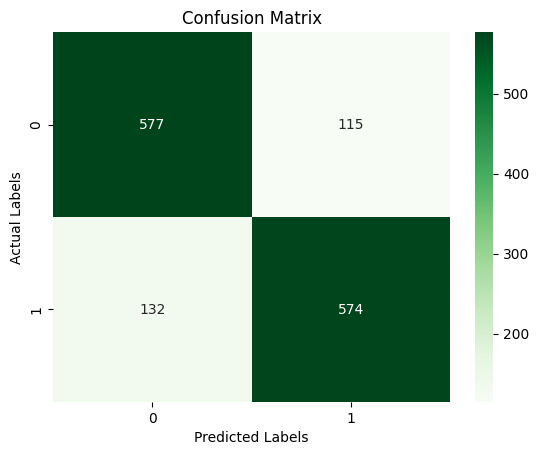

In [26]:
# 5. Analysis (Matriz)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = []

for dataset_config in datasets:
    df = load_and_prepare_data(dataset_config["filepath"],
                               dataset_config["text_column"],
                               dataset_config["label_column"])
    
    text_train, text_test, label_train, label_test = split_data(df)

    vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2), max_features=10000)
    X_train = vectorizer.fit_transform(text_train)
    X_test = vectorizer.transform(text_test)

    for classifier in classifiers:
        classifier.fit(X_train, label_train)
        y_pred = classifier.predict(X_test)
        predictions.append({
            "dataset": dataset_config["name"],
            "classifier": classifier.__class__.__name__,
            "label_test": label_test,
            "y_pred": y_pred
            })


if __name__ == "__main__":
    present_prediction = predictions[0]  # Exemplo: pegar a primeira predição para visualização
    dataset_name = present_prediction["dataset"]
    classifier_name = present_prediction["classifier"]

    label_test = present_prediction["label_test"]
    y_pred = present_prediction["y_pred"]
    confusion_metrics = confusion_matrix(label_test, y_pred)

    class_names = np.unique(np.concatenate((label_test, y_pred)))
    sns.heatmap(confusion_metrics, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

In [99]:
# 4.2 Classification (Exemple Prediction) [0% ainda não testei nem estudei]
teste = tfidf_vectorizer.transform(["Você é um lindo"])
rf.predict(teste)

array([0])

In [121]:
# 4.2 Classification (Exemple Prediction) [0% ainda não testei nem estudei]
teste = tfidf_vectorizer.transform(["Você é um lixo"])
rf.predict(teste)

array([0])